In [1]:
import seaborn as sns
import pickle
import os
import numpy as np
import pandas as pd
import scanpy
import umap
import networkx as nx
import torch
import torch.nn as nn
import scvelo as scv

from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from collections import Counter
from veloproj import *


In [2]:
method_name_mapping = {
 "stc_mode":"scVelo (stc)", 
 "dyn_mode":"scVelo (dyn)",
 "Cohort AutoEncoder":"veloAE",
 "Baseline AutoEncoder":"AE",
 "Ablation GCN Only": "AE w/ CohAgg",
 "Ablation AttComb Only": "AE w/ AttComb",
 "Baseline PCA": "PCA",
 "Baseline FA": "FA",                       
 }

def short_metric_name(metric):
    return {"Cross-Boundary Transition Score (A->B)":"CBTrans",
                  "Cross-Boundary Velocity Coherence (A->B)":"CBVCoh",
                  "Cross-Boundary Direction Correctness (A->B)":"CBDir",
                  "In-cluster Confidence":"ICConf",
                  "In-cluster Coherence":"ICVCoh"
                 }[metric]

def dis_method_name(method):
    return method_name_mapping.get(method, None)

def dis_group_name(group, metric):
    return "->".join(group) if metric.startswith('CB') else group
    
def to_dataframe(res):
    df_data = []
    for method, method_res in res.items():
        method = dis_method_name(method)
        if method is None:
            continue
        print(method)
        for metric, metric_res in method_res.items():
            metric = short_metric_name(metric)
            print(metric)
            for group, values in metric_res.items():
                group = dis_group_name(group, metric)
                print("\t", group, ": ", np.mean(values))
                for a_score in values:
                    df_data.append({"method":method,
                                    "metric":metric,
                                    "group": group,
                                    "score": a_score
                                   })
    df_data = pd.DataFrame(df_data)
    return df_data

def generate_plots(df_data, dataset, cbgroups, icgroups):
    for i, m in enumerate(df_data.metric.unique(), 1):
        print(m)
        df = df_data.query('metric == "{}"'.format(m))
        tgt_group = cbgroups if m.startswith("CB") else icgroups
        dfs = [df.query('group == "{}"'.format(grp)) for grp in tgt_group]
        if len(dfs) == 0:
            continue
        df = pd.concat(dfs, ignore_index=True)
        g = sns.catplot(x="method", y="score",
                    data=df, kind="box",
                    palette="Set3",
                    showfliers = False,   
                   )
        g.savefig("./figures/{}_{}".format(dataset, m), dpi=350)

def generate_plots(df_data, dataset, cbgroups, icgroups):
    for i, m in enumerate(df_data.metric.unique(), 1):
        print(m)
        df = df_data.query('metric == "{}"'.format(m))
        tgt_group = cbgroups if m.startswith("CB") else icgroups
        dfs = [df.query('group == "{}"'.format(grp)) for grp in tgt_group]
        if len(dfs) == 0:
            continue
        df = pd.concat(dfs, ignore_index=True)
        g = sns.catplot(x="method", y="score",
                    data=df, kind="box",
                    palette="Set3",
                    showfliers = False,   
                   )
        g.savefig("./figures/{}_{}".format(dataset, m), dpi=350)
            

## Generate boxplots for metrics

scVelo (stc)
CBTrans
	 0->15 :  0.18046935
	 15->30 :  0.18492216
	 30->60 :  0.23317614
	 60->120 :  0.26242688
CBVCoh
	 0->15 :  0.8819014
	 15->30 :  0.8492638
	 30->60 :  0.88575584
	 60->120 :  0.94947964
CBDir
	 0->15 :  0.1876439061902281
	 15->30 :  0.18311435541804788
	 30->60 :  0.2605115613326429
	 60->120 :  0.3797041202025015
ICVCoh
	 0 :  0.9148035
	 120 :  0.9610712
	 15 :  0.86902803
	 30 :  0.8744441
	 60 :  0.9512439
ICConf
	 0 :  0.5655437985422628
	 120 :  0.521134286881443
	 15 :  0.5152934900207046
	 30 :  0.5523746173429888
	 60 :  0.6306864593274655
veloAE
CBTrans
	 0->15 :  0.7890905
	 15->30 :  0.7483689
	 30->60 :  0.56591856
	 60->120 :  0.7032001
CBVCoh
	 0->15 :  0.9999832
	 15->30 :  0.99998534
	 30->60 :  0.99998283
	 60->120 :  0.99998116
CBDir
	 0->15 :  0.7071380247168556
	 15->30 :  0.4143092298727301
	 30->60 :  0.27588544711940727
	 60->120 :  0.17018836819244593
ICVCoh
	 0 :  0.99998355
	 120 :  0.99998546
	 15 :  0.9999867
	 30 :  0.9999868
	 60 

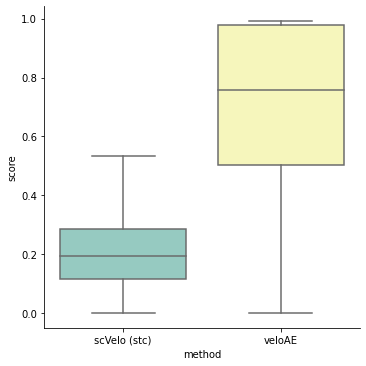

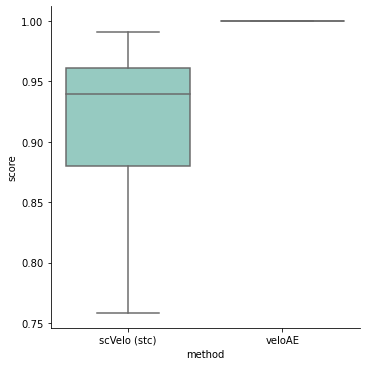

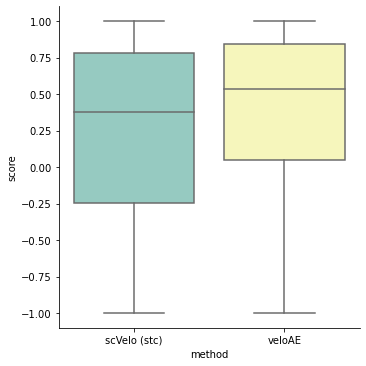

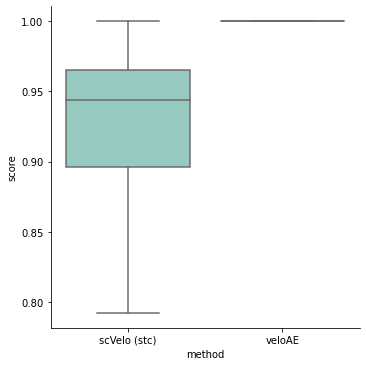

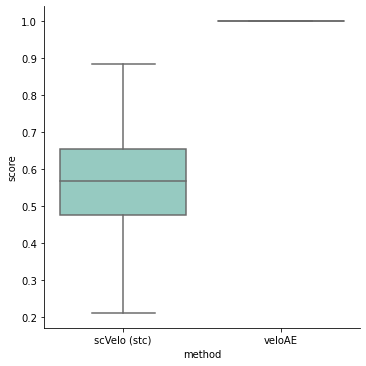

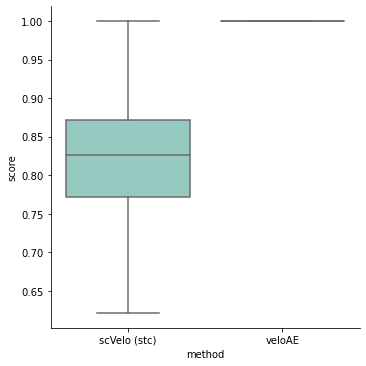

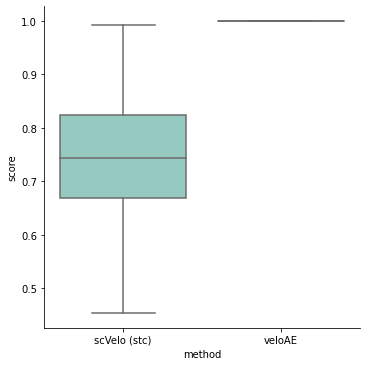

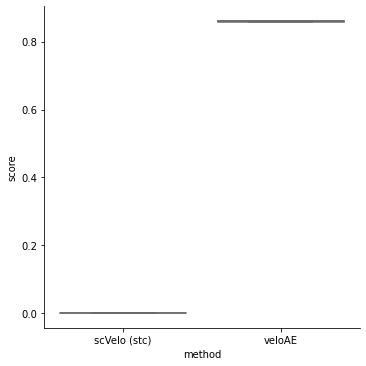

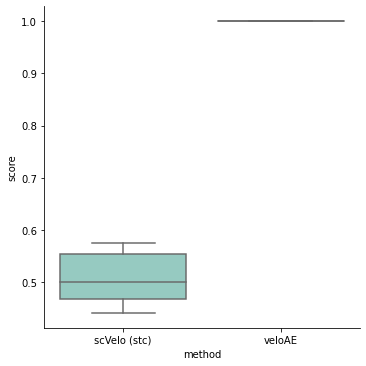

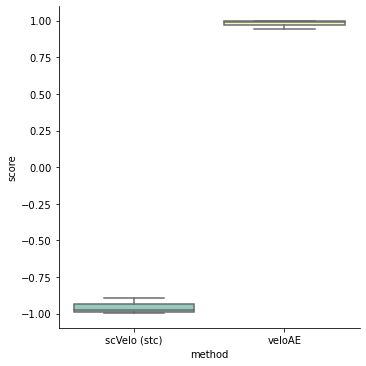

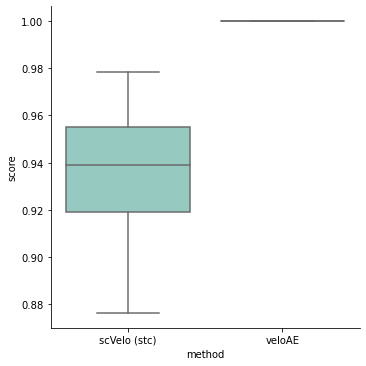

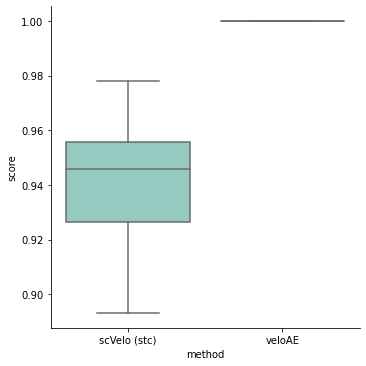

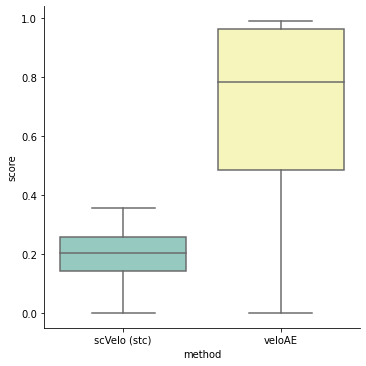

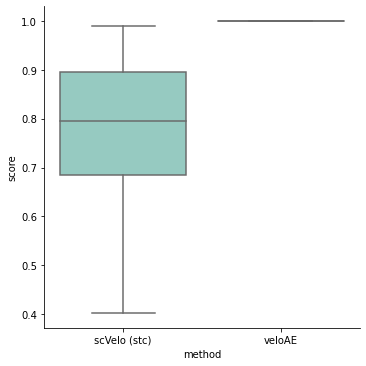

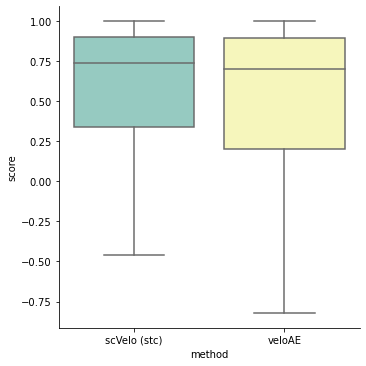

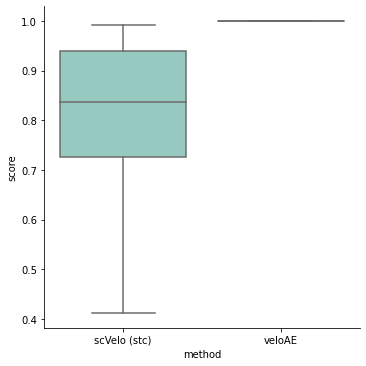

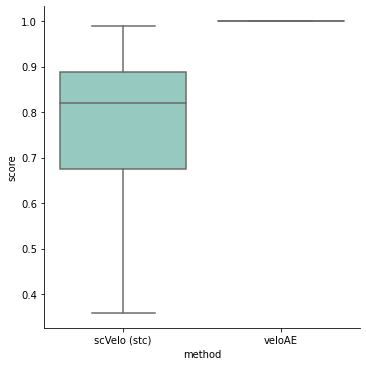

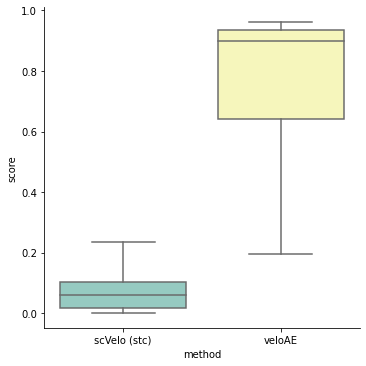

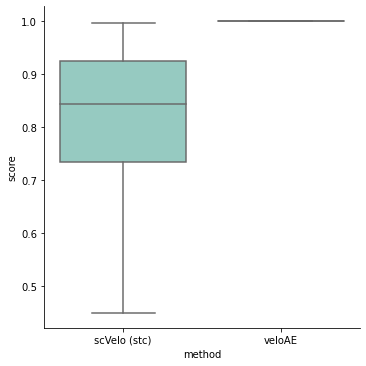

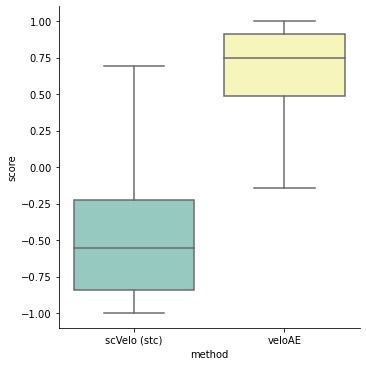

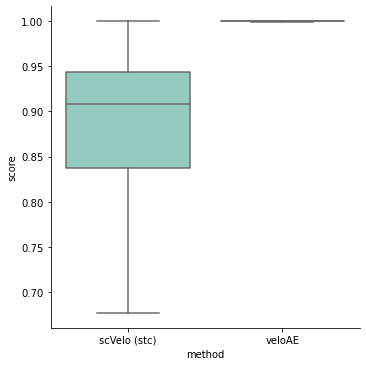

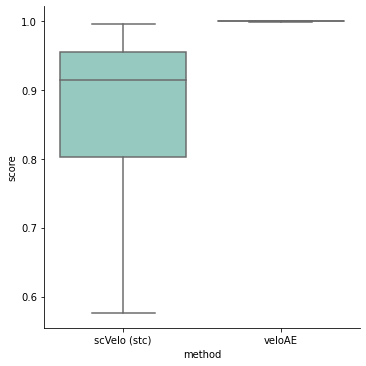

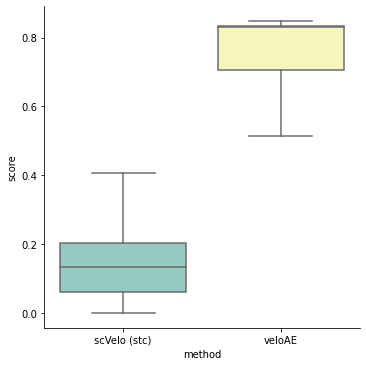

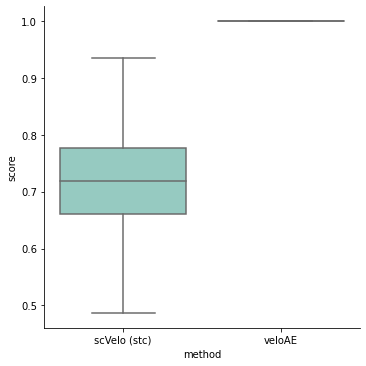

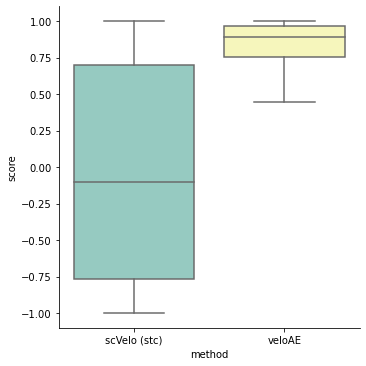

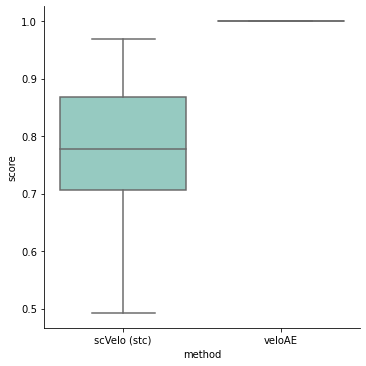

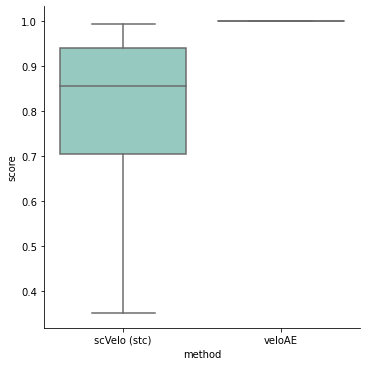

In [3]:
if not os.path.exists("./figures"):
    os.makedirs("./figures")
    
paths = ["../scNTseq/CohAE_scNT.pkl", 
         "../scEUseq/CohAE_scEU.pkl", 
         "../dentategyrus/CohAE_dentategyrus.pkl",
         "../pancreas/CohAE_pancreas.pkl",
         "../Melania_Erythroid_human/CohAE_Melania_Erythroid_human.pkl",
         "../Melania_Erythroid_mouse/CohAE_Melania_Erythroid_mouse.pkl",
        ]
groups = [(["0->15", "15->30", "30->60", "60->120"], 
           ["0", "15", "30", "60", "120"]), 
          ([], [1, 2]), 
          (['OPC->OL'],['OPC', 'OL']),
          (["Ngn3 low EP->Ngn3 high EP", "Ngn3 high EP->Fev+", "Fev+->Alpha", "Fev+->Beta", "Fev+->Delta", "Fev+->Epsilon"],
           ["Ngn3 low EP", "Ngn3 high EP", "Fev+", "Alpha", "Beta", "Delta", "Epsilon"]),
          (["Early Erythroid->Mid  Erythroid", 'Mid  Erythroid->Late Erythroid'], 
           ["Early Erythroid", "Mid  Erythroid", "Late Erythroid"]),
          (["Erythroid1->Erythroid2", "Erythroid2->Erythroid3"], 
           ['Erythroid1', 'Erythroid2', 'Erythroid3']),
         ]
dfs = []
for path, (cbg, icg) in zip(paths, groups): 
    dataset = path.split("_")[-1].split(".")[0]
    with open(path, 'rb') as infile:
        df = to_dataframe(pickle.load(infile))
        generate_plots(df, dataset, cbg, icg)
    dfs.append(df)

##  Compute Scores for Table

In [4]:
datasets = ["scNTseq", "scEUseq", "dentategyrus", "pancreas", "Melania_Erythroid_human", "Melania_Erythroid_mouse"]
groups = [(["0->15", "15->30", "30->60", "60->120"], 
           ["0", "15", "30", "60", "120"]), 
          ([], [1, 2]), 
          (['OPC->OL'],['OPC', 'OL']),
          (["Ngn3 low EP->Ngn3 high EP", "Ngn3 high EP->Fev+", "Fev+->Alpha", "Fev+->Beta", "Fev+->Delta", "Fev+->Epsilon"],
           ["Ngn3 low EP", "Ngn3 high EP", "Fev+", "Alpha", "Beta", "Delta", "Epsilon"]),
          (["Early Erythroid->Mid  Erythroid", 'Mid  Erythroid->Late Erythroid'], 
           ["Early Erythroid", "Mid  Erythroid", "Late Erythroid"]),
          (["Erythroid1->Erythroid2", "Erythroid2->Erythroid3"], 
           ['Erythroid1', 'Erythroid2', 'Erythroid3']),
         ]
dfs = []
for dataset, (cbg, icg) in zip(datasets, groups):
    _dfs = []
    for prefix in ['baseline', 'CohAE', 'dyn']:
        path = "../{}/{}_{}.pkl".format(dataset, prefix, dataset[:4] if dataset in ['scNTseq', 'scEUseq'] else dataset)
        with open(path, 'rb') as infile:
            _dfs.append(to_dataframe(pickle.load(infile)))
    _dfs[0] = _dfs[0].loc[_dfs[0].method != "scVelo (stc)", :] # keep only those in veloAE results
    _dfs[-1] = _dfs[-1].loc[_dfs[-1].method != "scVelo (stc)", :] # keep only those in dynamical mode results
    df = pd.concat(_dfs, ignore_index=True)            
    dfs.append(df)

scVelo (stc)
CBTrans
	 0->15 :  0.18051782
	 15->30 :  0.18487221
	 30->60 :  0.23318258
	 60->120 :  0.26257157
CBVCoh
	 0->15 :  0.8822476
	 15->30 :  0.8497245
	 30->60 :  0.8860252
	 60->120 :  0.9495538
CBDir
	 0->15 :  0.18786003770086088
	 15->30 :  0.18276909526616839
	 30->60 :  0.26048335897839736
	 60->120 :  0.37983926077447216
ICVCoh
	 0 :  0.915023
	 120 :  0.9611259
	 15 :  0.8694032
	 30 :  0.8747747
	 60 :  0.95134073
ICConf
	 0 :  0.5655646301155922
	 120 :  0.5211546006816554
	 15 :  0.5153005838784248
	 30 :  0.5523763634938027
	 60 :  0.6307276948395397
AE
CBTrans
	 0->15 :  0.13759603
	 15->30 :  0.12868418
	 30->60 :  0.04168049
	 60->120 :  0.040592507
CBVCoh
	 0->15 :  0.9999812
	 15->30 :  0.9999785
	 30->60 :  0.99997723
	 60->120 :  0.99997437
CBDir
	 0->15 :  0.5401848462445571
	 15->30 :  0.41344952104104854
	 30->60 :  0.18491266242813761
	 60->120 :  -0.16229981835578938
ICVCoh
	 0 :  0.9999848
	 120 :  0.9999857
	 15 :  0.9999817
	 30 :  0.9999808
	 60 

In [5]:
# datasets = ["scNTseq", "scEUseq", "dentategyrus"]
mean_records = {}
std_records = {}

for dataset, df, group in zip(datasets, dfs, groups):
    for method in df.method.unique():
        m_df = df.query('method == "{}"'.format(method))
        avg_metric, std_metric = {}, {}
        for metric in m_df.metric.unique():
            _group = group[0] if metric.startswith("CB") else group[1]
            if len(_group) == 0: continue
            loc_df = m_df.query('metric == "{}"'.format(metric))
            loc_df = pd.concat([loc_df.query('group == "{}"'.format(_g)) for _g in _group], ignore_index=True)
            avg_metric["{}_{}".format(dataset, metric)] =  loc_df.groupby('group').mean().score.mean()
            std_metric["{}_{}".format(dataset, metric)] = loc_df.groupby('group').std().score.mean()
        if not method in mean_records:
            mean_records[method] = {}
            std_records[method] = {}
        mean_records[method].update(avg_metric)
        std_records[method].update(std_metric)

df_mean = pd.DataFrame(mean_records).T
# new_index = df_mean.index.values
# new_index[new_index == "LowDim"] = "veloAE"
# new_index[new_index == "RawDim"] = "scVelo"
# df_mean.index = new_index
df_std = pd.DataFrame(std_records).T
# df_std.index = new_index        

In [6]:
df_mean.loc[['scVelo (stc)', 'scVelo (dyn)', 'FA', 'PCA', 'AE', 'veloAE', "AE w/ CohAgg", "AE w/ AttComb"],
            ['scNTseq_ICConf', 'scNTseq_ICVCoh',  
             'scNTseq_CBTrans', 'scNTseq_CBVCoh', 'scNTseq_CBDir', 
             'dentategyrus_ICConf',  'dentategyrus_ICVCoh', 'dentategyrus_CBTrans',
             'dentategyrus_CBVCoh', 'dentategyrus_CBDir',
             'scEUseq_ICConf', 'scEUseq_ICVCoh',
             'pancreas_ICConf', 'pancreas_ICVCoh',
             'pancreas_CBTrans', 'pancreas_CBVCoh', 'pancreas_CBDir',
             'Melania_Erythroid_human_ICConf', 'Melania_Erythroid_human_ICVCoh',
             'Melania_Erythroid_human_CBTrans', 'Melania_Erythroid_human_CBVCoh', 'Melania_Erythroid_human_CBDir', 
             'Melania_Erythroid_mouse_ICConf', 'Melania_Erythroid_mouse_ICVCoh',
             'Melania_Erythroid_mouse_CBTrans', 'Melania_Erythroid_mouse_CBVCoh', 'Melania_Erythroid_mouse_CBDir', 
            ]]

,scNTseq_ICConf,scNTseq_ICVCoh,scNTseq_CBTrans,scNTseq_CBVCoh,scNTseq_CBDir,dentategyrus_ICConf,dentategyrus_ICVCoh,dentategyrus_CBTrans,dentategyrus_CBVCoh,dentategyrus_CBDir,...,Melania_Erythroid_human_ICConf,Melania_Erythroid_human_ICVCoh,Melania_Erythroid_human_CBTrans,Melania_Erythroid_human_CBVCoh,Melania_Erythroid_human_CBDir,Melania_Erythroid_mouse_ICConf,Melania_Erythroid_mouse_ICVCoh,Melania_Erythroid_mouse_CBTrans,Melania_Erythroid_mouse_CBVCoh,Melania_Erythroid_mouse_CBDir
scVelo (stc),0.557007,0.914118,0.215249,0.891600,0.252743,0.937412,0.936344,0.000000,0.508540,-0.886100,...,0.856878,0.876873,0.063880,0.821784,-0.525327,0.776113,0.772521,0.132281,0.712939,-0.100238
scVelo (dyn),0.824302,0.953167,0.186471,0.935905,0.272601,0.920600,0.829447,0.030199,0.198984,-0.085505,...,0.914369,0.929816,0.084534,0.907132,-0.503559,0.857212,0.915050,0.041811,0.919564,-0.216445
FA,0.199000,0.329715,0.021769,0.144974,-0.100476,0.645010,0.657654,0.000000,0.228966,0.671455,...,0.282924,0.296652,0.049767,0.218713,0.100176,0.292201,0.334111,0.106911,0.262321,0.208606
PCA,0.336660,0.414775,0.039556,0.319663,-0.352734,0.881084,0.887606,0.000000,0.387951,-0.817778,...,0.865192,0.871079,0.190743,0.847142,-0.335837,0.991165,0.992981,0.159875,0.990261,-0.613967
AE,0.999973,0.999983,0.087138,0.999978,0.244062,0.998925,0.999331,0.000000,0.955055,-0.493657,...,0.983502,0.985015,0.111186,0.971386,-0.002314,0.983764,0.986805,0.087282,0.953044,0.122425
veloAE,0.999984,0.999985,0.701645,0.999983,0.391880,0.999994,0.999995,0.858587,0.999952,0.980858,...,0.999581,0.999570,0.765576,0.999572,0.649918,0.999861,0.999915,0.746233,0.999904,0.827646
AE w/ CohAgg,0.999991,0.999992,0.061403,0.999990,0.436351,0.999815,0.999881,0.000000,0.993338,-0.896857,...,0.999940,0.999944,0.033915,0.999914,-0.446089,0.999803,0.999806,0.109989,0.999741,0.601187
AE w/ AttComb,0.999084,0.999115,0.426195,0.998949,0.334679,0.999219,0.999341,0.027471,0.993241,0.953957,...,0.995100,0.995318,0.132182,0.996890,0.300301,0.986924,0.987920,0.045221,0.986487,0.254458


In [7]:
# keep only ICVCoh and CBDir for paper
print(df_mean.round(4).loc[['scVelo (stc)', 'scVelo (dyn)', 'FA', 'PCA', 'AE', 'veloAE', "AE w/ CohAgg", "AE w/ AttComb"],
                  ['scNTseq_ICVCoh', 'scNTseq_CBDir',
                   'dentategyrus_ICVCoh', 'dentategyrus_CBDir',
                   'scEUseq_ICVCoh',
                   'Melania_Erythroid_mouse_ICVCoh', 'Melania_Erythroid_mouse_CBDir',
                   'Melania_Erythroid_human_ICVCoh', 'Melania_Erythroid_human_CBDir',
                   'pancreas_ICVCoh', 'pancreas_CBDir',
                   ]].to_latex())

\begin{tabular}{lrrrrrrrrrrr}
\toprule
{} &  scNTseq\_ICVCoh &  scNTseq\_CBDir &  dentategyrus\_ICVCoh &  dentategyrus\_CBDir &  scEUseq\_ICVCoh &  Melania\_Erythroid\_mouse\_ICVCoh &  Melania\_Erythroid\_mouse\_CBDir &  Melania\_Erythroid\_human\_ICVCoh &  Melania\_Erythroid\_human\_CBDir &  pancreas\_ICVCoh &  pancreas\_CBDir \\
\midrule
scVelo (stc)  &          0.9141 &         0.2527 &               0.9363 &             -0.8861 &          0.8297 &                          0.7725 &                        -0.1002 &                          0.8769 &                        -0.5253 &           0.8360 &          0.4787 \\
scVelo (dyn)  &          0.9532 &         0.2726 &               0.8294 &             -0.0855 &          0.7286 &                          0.9151 &                        -0.2164 &                          0.9298 &                        -0.5036 &           0.7846 &          0.4678 \\
FA            &          0.3297 &        -0.1005 &               0.6577 &             

In [8]:
# df_mean.round(4).loc[['scVelo (stc)', 'scVelo (dyn)', 'FA', 'PCA', 'AE', 'veloAE', "AE w/ CohAgg", "AE w/ AttComb"],
#                   ['scNTseq_ICVCoh', 'scNTseq_CBDir',
#                    'dentategyrus_ICVCoh', 'dentategyrus_CBDir',
#                    'scEUseq_ICVCoh',
#                    'Melania_Erythroid_mouse_ICVCoh', 'Melania_Erythroid_mouse_CBDir',
#                    'Melania_Erythroid_human_ICVCoh', 'Melania_Erythroid_human_CBDir',
#                    'pancreas_ICVCoh', 'pancreas_CBDir',
#                    ]].to_csv("metrics.csv")